# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Three-way SoftMax classifier of normal, non-vascular MCI, and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime
from copy import deepcopy

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm 

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional
from itertools import cycle

# custom package
from utils.eeg_dataset import *

In [3]:
# notebook name
def get_notebook_name():
    import ipynbname
    return ipynbname.name()

nb_fname = get_notebook_name()

In [4]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [5]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.9.0
cuda is available.


In [6]:
# Data file path
data_path = r'dataset/02_Curated_Data/'
meta_path = os.path.join(data_path, 'metadata_debug.json')

with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


#### Wrap the splitted data using PyTorch Dataset

In [10]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92779783393502 9.817569889945597


In [11]:
crop_length = 200*60 # 1 minutes

composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=crop_length),
                               EEGNormalizePerSignal(),
                               EEGToTensor()])

train_dataset = EEGDataset(data_path, metadata_train, composed)
val_dataset = EEGDataset(data_path, metadata_val, composed)
test_dataset = EEGDataset(data_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 12000])
{'signal': tensor([[ 0.0527,  0.0139,  0.0472,  ..., -0.1632, -0.1632, -0.2075],
        [ 0.2563,  0.2563,  0.1229,  ...,  0.4965,  0.4965,  0.4698],
        [-1.9746, -1.9392, -1.8328,  ...,  0.1875,  0.1166,  0.0457],
        ...,
        [ 0.4201,  0.4201,  0.3180,  ..., -0.6015, -0.6015, -0.6015],
        [ 0.7333,  0.6644,  0.5264,  ..., -0.3013, -0.2324, -0.2324],
        [-0.0888,  0.1175,  0.1313,  ...,  0.3238,  0.3101,  0.3513]]), 'age': tensor(-1.2149), 'class_label': tensor(0), 'metadata': {'serial': '01012', 'edfname': '01212635_270515', 'birth': '1956-06-01', 'record': '2015-05-27T09:37:24', 'age': 58, 'dx1': 'cb_normal', 'label': ['normal', 'cb_normal'], 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002'], [400, 'Eyes Open'], [7918, 'Eyes Closed'], [14091, 'Eyes Open'], [18208, 'Eyes Closed'], [24256, 'Eyes Open'], [30724, 'Eyes Closed'], [36562, 'Eyes Open'], [42190, 'Eyes Closed'], [48910, 'Eyes Open'], [55126, 'Eyes Closed'], [

#### Data loader test

In [12]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32]) 32
1 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32]) 32
2 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32]) 32
3 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32]) 32
4 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32]) 32


#### Train, validation, test dataloaders

In [13]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Define Transformer Model

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    from torch.utils.tensorboard import SummaryWriter
    
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

#### Transformer on top of CNN

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 200*60):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        return x + self.pe[:x.size(0)]

In [16]:
class TransformerCNN(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=7, n_channel=512, 
                 dropout=0.3, n_encoders=2, crop_length=200*60, use_age=True):
        super().__init__()
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
    
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7, stride=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        
        x = torch.zeros((1, n_input, crop_length))
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        
        self.pos_encoder = PositionalEncoding(n_channel, max_len=x.shape[2])
        encoder_layers = nn.TransformerEncoderLayer(n_channel, 8, n_channel, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_encoders)

        self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel, n_channel)                
                    
        self.dropout = nn.Dropout(p=dropout)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
                
    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        
        x = x.permute(2, 0, 1) # minibatch, dimension, length --> length, minibatch, dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0) # length, minibatch, dimension --> minibatch, dimension, length
        
        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x    

In [17]:
def generate_TransformerCNN():
    return TransformerCNN(n_input=train_dataset[0]['signal'].shape[0], n_output=3, 
                          n_channel=512, dropout=0.3, crop_length=crop_length, use_age=True)

In [18]:
model = generate_TransformerCNN()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'Transformer-CNN')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


TransformerCNN(
  (conv1): Conv1d(20, 512, kernel_size=(35,), stride=(7,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(512, 512, kernel_size=(7,), stride=(3,))
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1

-----

## Some useful functions for training

In [19]:
def check_val_accuracy(model, repeat=1):
    model.eval()
    
    correct, total = (0, 0)
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in val_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # val accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    
    # for test accuracy
    correct, total = (0, 0) 
    
    # for confusion matrix
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    # for test debug
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].item(), 
                   'Acc': 0, 
                   'Pred': [0] * C} for data in test_dataset}
    
    # for ROC curve
    score = None
    target = None
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in test_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                y = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                s = F.softmax(output, dim=1)
                pred = F.log_softmax(output, dim=1)

                # test accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]

                if score is None:
                    score = s.detach().cpu().numpy()
                    target = y.detach().cpu().numpy()
                else:
                    score = np.concatenate((score, s.detach().cpu().numpy()), axis=0)
                    target = np.concatenate((target, y.detach().cpu().numpy()), axis=0)

                # confusion matrix
                test_confusion += calculate_confusion_matrix(pred, y)

                # test debug
                for n in range(pred.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                    test_debug[serial]['Pred'][pred[n].item()] += 1
                    acc = test_debug[serial]['Pred'][y[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                    test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
        
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug, score, target)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [20]:
def draw_loss_plot(losses, lr_decay_step):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(8.0, 3.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    N = len(losses)
    x = np.arange(1, N + 1)
    ax.plot(x, losses)
    
    if type(lr_decay_step) is list:
        ax.vlines(lr_decay_step, 0, 1, transform=ax.get_xaxis_transform(), 
                  colors='m', alpha=0.5, linestyle='solid')
    else:
        x2 = np.arange(lr_decay_step, N, lr_decay_step)
        ax.vlines(x2, 0, 1, transform=ax.get_xaxis_transform(), 
                  colors='m', alpha=0.5, linestyle='solid')
    # ax.vlines([1, N], 0, 1, transform=ax.get_xaxis_transform(), 
    #           colors='k', alpha=0.7, linestyle='solid')
    
    ax.set_xlim(left=0)
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)

def draw_accuracy_history(train_acc_history, val_acc_history, history_interval, lr_decay_step):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(8.0, 3.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    N = len(train_acc_history) * history_interval
    x = np.arange(history_interval, N + 1, history_interval)
    ax.plot(x, train_acc_history, 'r-', label='Train accuracy')
    ax.plot(x, val_acc_history, 'b-', label='Validation accuracy')
    
    if type(lr_decay_step) is list:
        ax.vlines(lr_decay_step, 0, 1, transform=ax.get_xaxis_transform(), 
                  colors='m', alpha=0.5, linestyle='solid')
    else:
        x2 = np.arange(lr_decay_step, N + 1, lr_decay_step)
        ax.vlines(x2, 0, 1, transform=ax.get_xaxis_transform(), 
                  colors='m', alpha=0.5, linestyle='solid')
    # ax.vlines([history_interval, N], 0, 1, transform=ax.get_xaxis_transform(), 
    #           colors='k', alpha=0.7, linestyle='solid')
    
    ax.set_xlim(left=0)
    ax.legend(loc='lower right')
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [21]:
def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(3.0, 3.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)
    

def draw_roc_curve(score, target):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    # Binarize the output
    n_classes = len(class_label_to_type)
    target = label_binarize(target, classes=np.arange(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(target[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # draw class-agnostic ROC curve
    fig = plt.figure(num=1, clear=True, figsize=(8.5, 4.0), constrained_layout=True)
    ax = fig.add_subplot(1, 2, 1)
    lw = 1.5
    colors = cycle(['limegreen', 'mediumpurple', 'darkorange', 
                    'dodgerblue', 'lightcoral', 'goldenrod', 
                    'indigo', 'darkgreen', 'navy', 'brown'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (area = {1:0.2f})'
                ''.format(class_label_to_type[i], roc_auc[i]))    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Class-Wise ROC Curves')
    ax.legend(loc="lower right")

    # Plot class-aware ROC curves
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle='-', linewidth=lw)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle='-', linewidth=lw)

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Class-Agnostic ROC Curves')
    ax.legend(loc="lower right")
    plt.show()
    fig.clear()
    plt.close(fig)

In [22]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, iters):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
        correct, total = (0, 0)
        
        i = 1
        while True:
            for sample_batched in train_loader:
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                output = model(x, age)
                pred = F.log_softmax(output, dim=1)
                loss = F.nll_loss(pred, target)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]
                
                i += 1
                if i >= iters:
                    break
            if i >= iters:
                break
        
        train_accuracy = 100.0 * correct / total
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, constrained_layout=True) # figsize=(6.0, 6.0)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    

    ax.scatter(*max(learning_rate_record, key=lambda x: x[1]), 
               s=150, c='w', marker='o', edgecolors='limegreen')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
        
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train models

In [25]:
model_pool = []

model_dict = {}
model_dict['name'] = 'Transformer-CNN'
model_dict['generator'] = generate_TransformerCNN
model_dict['lr_start'] = 4.82833e-03
model_pool.append(model_dict)

pprint.pp(model_pool, width=150)

[{'name': 'Transformer-CNN', 'generator': <function generate_TransformerCNN at 0x000001F86DE67B80>, 'lr_start': 0.00482833}]


In [26]:
for model_dict in model_pool:
    if model_dict['lr_start'] is None:
        print(f'{model_dict["name"]} LR searching..')
        model = model_dict['generator']().to(device)
        model.train()
        
        record = learning_rate_search(model, min_log_lr=-4.5, max_log_lr=-1.4, 
                                      trials=300, iters=30)
        
        draw_learning_rate_record(record)
        best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]
        model_dict['lr_start'] = 10 ** best_log_lr
        
        print(f'best lr {model_dict["lr_start"]:.5e} / log_lr {best_log_lr}')
    else:
        print(f'{model_dict["name"]}: {model_dict["lr_start"]:.5e}')
        
    print('-' * 100)
        
pprint.pp(model_pool, width=150)

Transformer-CNN: 4.82833e-03
----------------------------------------------------------------------------------------------------
[{'name': 'Transformer-CNN', 'generator': <function generate_TransformerCNN at 0x000001F86DE67B80>, 'lr_start': 0.00482833}]


# iterations: 70000, # steps for LR decay: 56000


  0%|          | 0/70000 [00:00<?, ?it/s]

**************************************** Transformer-CNN train starts ****************************************


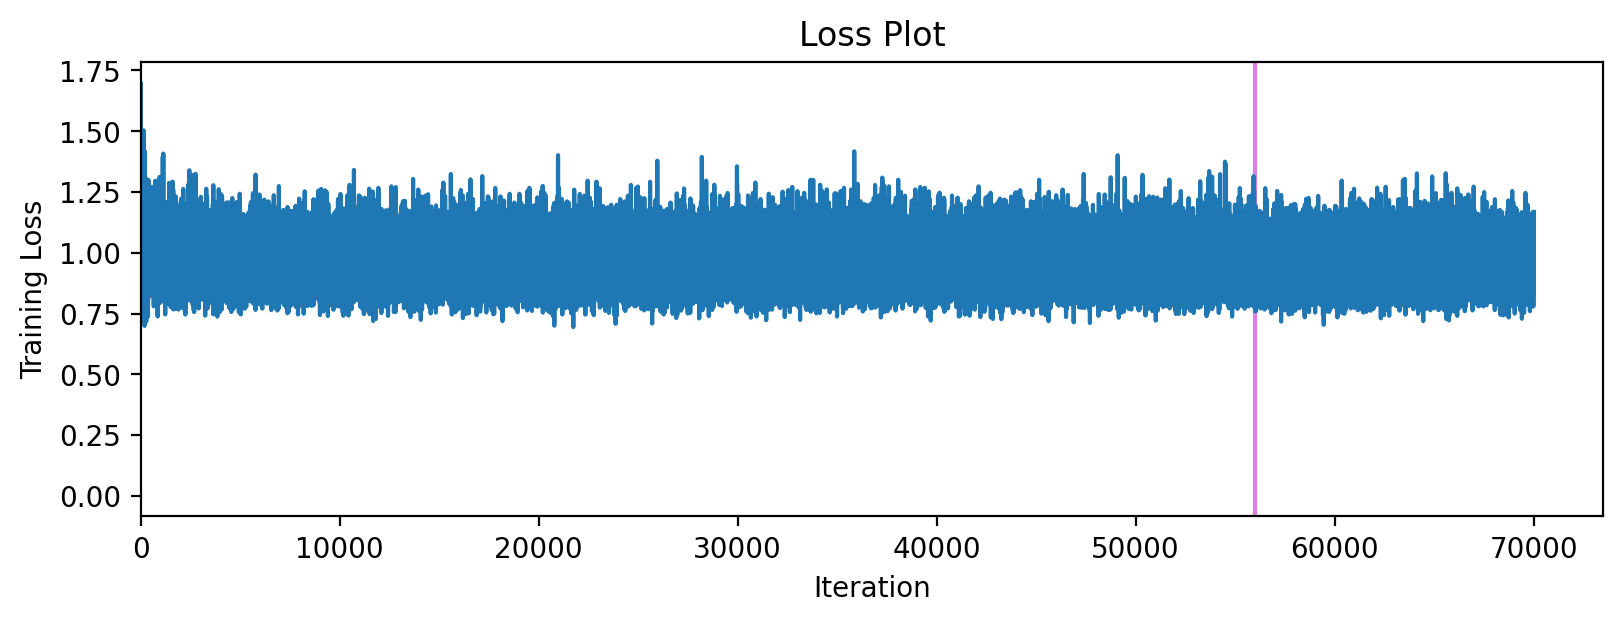

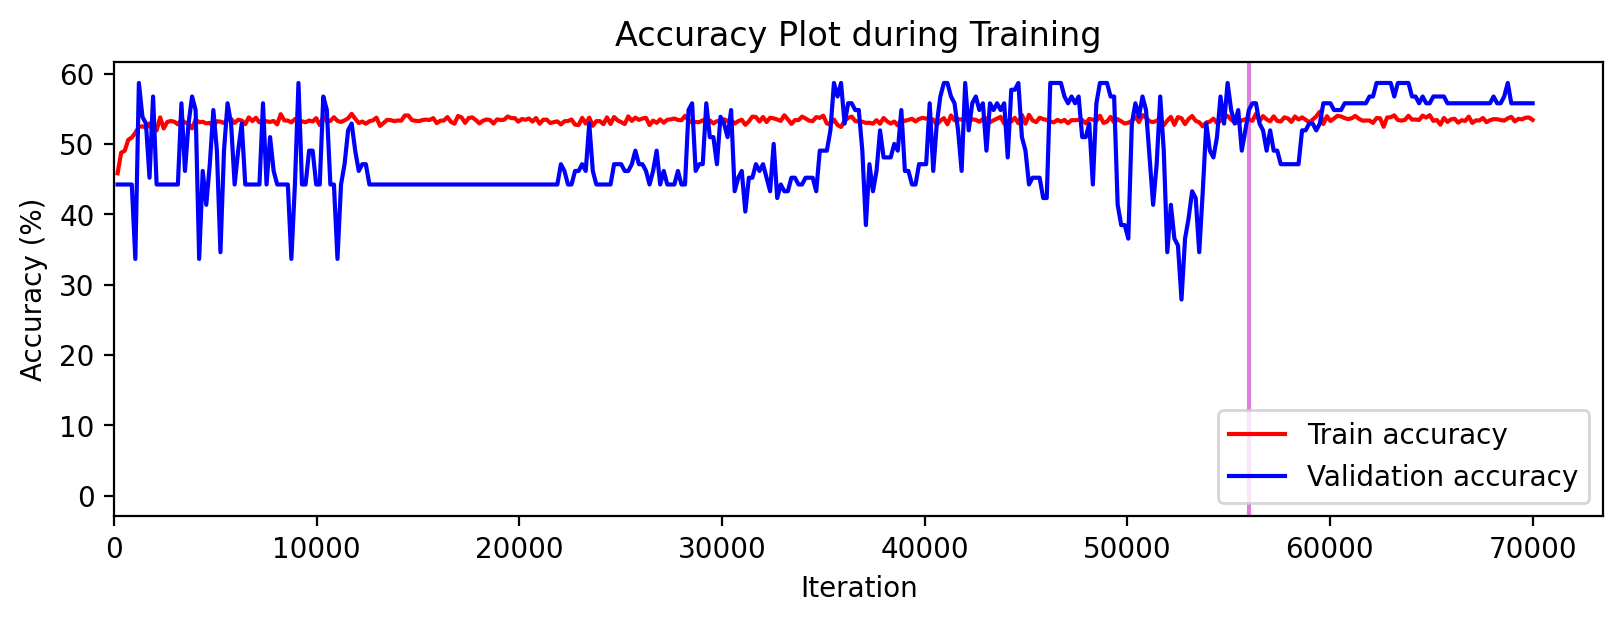


- 00 train accuracy 53.41%, best / last test accuracies 55.77% / 52.88%



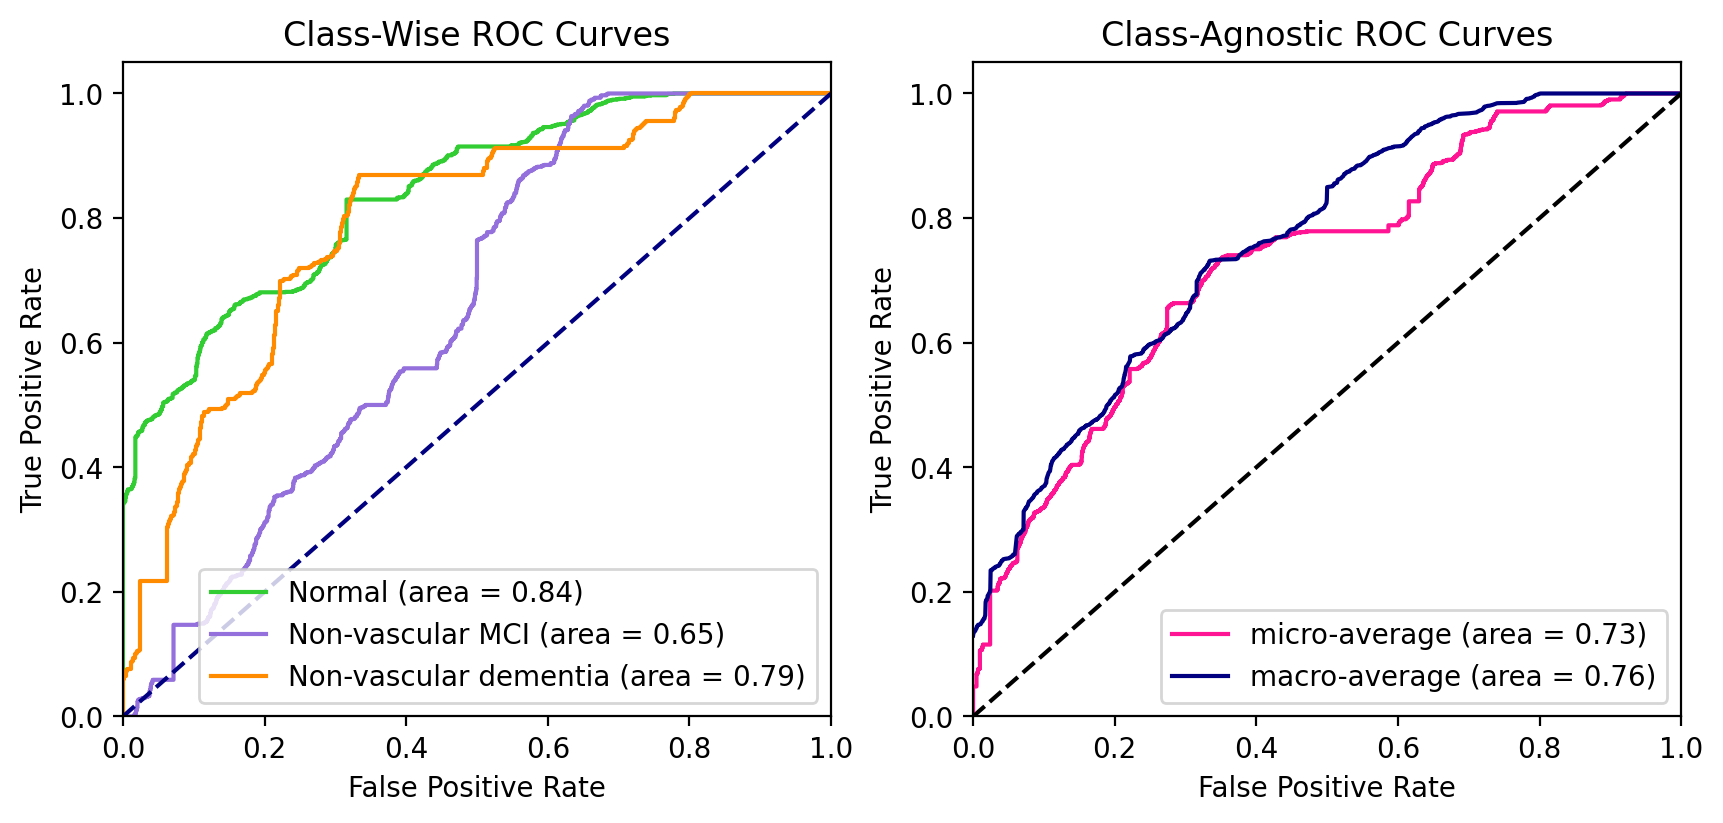

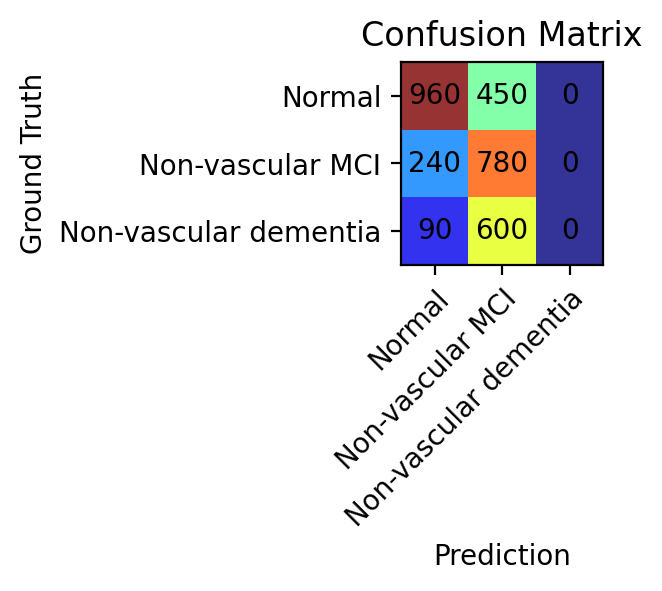

In [27]:
file_check = True
save_model = True
draw_result = True

# log path
log_path = f'history_temp/{nb_fname}/'
os.makedirs(log_path, exist_ok=True)

# train iterations
n_repeats = 1
n_iters = 70000
# n_iters = 12500 * ((200 * 60) // crop_length)
history_interval = n_iters // 400
lr_decay_step = round(n_iters * 0.8)

print(f'# iterations: {n_iters}, # steps for LR decay: {lr_decay_step}')

# progress bar
pbar = tqdm(total=len(model_pool) * n_iters * n_repeats)

# train process on model_pool
for model_dict in model_pool:
    print(f'{"*"*40} {model_dict["name"]} train starts {"*"*40}')
    best_r_test_acc = 0
    
    for r in range(n_repeats):
        if file_check:
            endwith = '' if n_repeats == 1 else f'_r{r:02d}'
            path = os.path.join(log_path, f'{model_dict["name"]}_log{endwith}')
            if os.path.isfile(path):
                log_dict = torch.load(path)
                # loss and accuracy plots
                if draw_result:
                    draw_loss_plot(log_dict["losses"], log_dict["lr_decay_step"])
                    draw_accuracy_history(log_dict["train_acc_history"], log_dict["val_acc_history"], 
                                          log_dict["history_interval"], log_dict["lr_decay_step"])
                script = f'- {r:02d} train accuracy {log_dict["train_acc_history"][-1]:.2f}%, '\
                f'best / last test accuracies {log_dict["best_test_accuracy"]:.2f}% / {log_dict["last_test_accuracy"]:.2f}% - file exists'
                print()
                print(script)
                print()
                pbar.update(n_iters)
                continue

        # load the model dict
        model = model_dict['generator']().to(device)
        
        model.train()
        lr_start = model_dict['lr_start']
        
        # configure for training
        optimizer = optim.AdamW(model.parameters(), lr=lr_start, weight_decay=1e-2)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)

        # log during training
        losses = []
        train_acc_history = []
        val_acc_history = []
        best_val_acc = 0
        correct, total = (0, 0)

        i = 0    
        while True:
            for sample_batched in train_loader:
                model.train()

                # load the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # forward pass
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)
                loss = F.nll_loss(pred, target)

                # backward and update
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

                # train accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # log
                losses.append(loss.item())
                pbar.update(1)
                i += 1

                # history
                if i % history_interval == 0:
                    train_acc = 100.0 * correct / total
                    train_acc_history.append(train_acc)
                    correct, total = (0, 0)

                    val_acc, _ = check_val_accuracy(model, repeat=5)
                    val_acc_history.append(val_acc)

                    if best_val_acc < val_acc:
                        best_val_acc = val_acc
                        best_model_state = deepcopy(model.state_dict())

                if i >= n_iters:
                    break
            if i >= n_iters:
                break
        
        # loss and accuracy plots
        if draw_result:
            draw_loss_plot(losses, lr_decay_step)
            draw_accuracy_history(train_acc_history, val_acc_history, history_interval, lr_decay_step)
            
        # calculate the test accuracies for best and last models
        last_model_state = deepcopy(model.state_dict())
        last_test_acc, last_test_confusion, last_test_debug, _, _ = check_test_accuracy(model, repeat=30)
        
        model.load_state_dict(best_model_state)
        best_test_acc, best_test_confusion, best_test_debug, _, _ = check_test_accuracy(model, repeat=30)

        # save the model if it is best among repeatedly trained models
        if save_model and best_r_test_acc < max(last_test_acc, best_test_acc):
            best_r_test_acc = max(last_test_acc, best_test_acc)
            model_state = last_model_state if best_test_acc < last_test_acc else best_model_state
            path = os.path.join(log_path, f'{model_dict["name"]}')
            torch.save(model_state, path)

        # leave the log
        endwith = '' if n_repeats == 1 else f'_r{r:02d}'
        path = os.path.join(log_path, f'{model_dict["name"]}_log{endwith}')
        log_dict = {}
        log_dict['model'] = model_dict['name']
        log_dict['num_params'] = count_parameters(model)
        log_dict['weight_decay'] = optimizer.defaults['weight_decay']
        log_dict['starting_lr'] = lr_start
        log_dict['final_lr'] = optimizer.param_groups[-1]["lr"]
        log_dict['history_interval'] = history_interval
        log_dict['lr_decay_step'] = lr_decay_step
        log_dict['losses'] = losses
        log_dict['train_acc_history'] = train_acc_history
        log_dict['val_acc_history'] = val_acc_history
        log_dict['best_test_accuracy'] = best_test_acc
        log_dict['best_test_confusion'] = best_test_confusion
        log_dict['best_test_debug'] = best_test_debug
        log_dict['last_test_accuracy'] = last_test_acc
        log_dict['last_test_confusion'] = last_test_confusion
        log_dict['last_test_debug'] = last_test_debug
        torch.save(log_dict, path)

        script = f'- {r:02d} train accuracy {train_acc:.2f}%, '\
        f'best / last test accuracies {best_test_acc:.2f}% / {last_test_acc:.2f}%'
        print()
        print(script)
        print()
    
    if draw_result and save_model:
        model = model_dict['generator']().to(device)
        path = os.path.join(log_path, f'{model_dict["name"]}')
        model.load_state_dict(torch.load(path))
        temp_result = check_test_accuracy(model, repeat=30)
        test_acc, test_confusion, test_debug, score, target = temp_result
        draw_roc_curve(score, target)
        draw_confusion(test_confusion)
        print('\n' * 2)
    print()

In [28]:
# log path
log_path = f'history_temp/{nb_fname}/'

pprint.pprint(model_pool)
print('\n' * 3)

# train process on model_pool
for model_dict in model_pool:
    for r in range(n_repeats):
        endwith = '' if n_repeats == 1 else f'_r{r:02d}'
        path = os.path.join(log_path, f'{model_dict["name"]}_log{endwith}')
        if os.path.isfile(path):
            log_dict = torch.load(path)
            script = f'{log_dict["num_params"]}\t'
            script += f'{log_dict["weight_decay"]:.2e}\t'
            script += f'{log_dict["starting_lr"]:.2e}\t'
            script += f'{len(log_dict["losses"])}\t'
            script += f'{log_dict["lr_decay_step"]}\t'
            script += f'{log_dict["train_acc_history"][-1]:.2f}%\t'
            script += f'{log_dict["best_test_accuracy"]:.2f}% / {log_dict["last_test_accuracy"]:.2f}%'
            print(script)

[{'generator': <function generate_TransformerCNN at 0x000001F86DE67B80>,
  'lr_start': 0.00482833,
  'name': 'Transformer-CNN'}]




5618179	1.00e-02	4.83e-03	70000	56000	53.41%	55.77% / 52.88%
